In [126]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from tensorflow.keras.datasets import mnist
import math

In [127]:
# load MNIST data
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_train = x_train.T
print(x_train.shape)

(784, 60000)


In [128]:
def get_full_mnist_data(x_train):
    return x_train
print(get_full_mnist_data(x_train).shape)

(784, 60000)


In [129]:
def get_mnist_data(x_train, batch_size):

    # segment the training data into required batch size
    num_batches = math.floor(x_train.shape[1]/batch_size)
    A_list = []

    for i in range(0, num_batches):

        if i + batch_size <= (x_train.shape[1]):
            A_list.append(x_train[:, i:i + batch_size])

    print("Number of batches:", len(A_list))
    print("Shape of each batch:", A_list[0].shape)

    return A_list

In [130]:
def streaming_svd(A_list, num_modes, forget_factor):

    modes_list = []  # To store the left singular vectors after each batch
    singular_values_list = []  # To store the singular values after each batch

    # initial data matrix
    A0 = A_list[0]

    # QR decomposition
    Q, R = np.linalg.qr(A0)

    # SVD of R
    U0, singular_values, _ = np.linalg.svd(R)

    # truncated left singular vectors
    truncated_U0 = U0[:, :num_modes]
    modes = np.matmul(Q, truncated_U0)

    # truncated singular values
    singular_values = singular_values[:num_modes]

    # store the results
    modes_list.append(modes)
    singular_values_list.append(singular_values)

    # Iterate over remaining batches
    for i in range(1, len(A_list)):

        # new data batch
        Ai = A_list[i]

        # QR decomposition after concatenation of new data
        prev_mode = modes_list[-1]
        prev_singular_values = singular_values_list[-1]
        prev_info = forget_factor * np.matmul(prev_mode, np.diag(prev_singular_values))
        Ai_concat = np.concatenate((prev_info, Ai), axis=1)

        # QR decomposition
        Q, R = np.linalg.qr(Ai_concat)

        # SVD of R
        Ui, singular_values, _ = np.linalg.svd(R)

        # truncated left singular vectors
        truncated_Ui = Ui[:, :num_modes]
        modes = np.matmul(Q, truncated_Ui)

        # truncated singular values
        singular_values = singular_values[:num_modes]

        # store the results
        modes_list.append(modes)
        singular_values_list.append(singular_values)

        # if i % 100 == 0:
        #   print(f"Batch {i}/{len(A_list)} completed")

    return modes_list, singular_values_list

In [131]:
# get a data list with each element as a new batch
batch_size = 50
num_batches = math.floor(x_train.shape[1]/batch_size)
A_list = get_mnist_data(x_train, batch_size)

Number of batches: 1200
Shape of each batch: (784, 50)


In [132]:
num_singular_values = 3
forget_factor = 1.0

start_time = time.time()
modes_list, singular_values_list = streaming_svd(A_list, num_singular_values, forget_factor)
end_time = time.time()

print("Time taken:", end_time - start_time, "seconds")

Time taken: 6.989323854446411 seconds


In [133]:
def get_grayscale(singular_vector):

    # Reshape the vector into a 28x28 image
    image = singular_vector.reshape(28, 28)

    # Normalize the singular vector to the range [0, 255] for visualization
    vector_min = image.min()
    vector_max = image.max()

    if vector_max - vector_min == 0:
        image_scaled = np.zeros_like(image)
    else:
        image_scaled = 255 * (image - vector_min) / (vector_max - vector_min)  # Scale to [0, 255]

    return image_scaled


In [134]:
def visualize_mnist_singular_vectors(U_list, n_vectors=3, output_file='mnist_singular_vectors_evolution.mp4'):

    def update_plot(frame):
        for i in range(n_vectors):
            vector = U_list[frame][:, i]
            image_scaled = get_grayscale(vector)
            imgs[i].set_array(image_scaled)
            titles[i].set_text(f"Singular Vector {i+1}\nBatch {frame+1}")
        return imgs + titles

    # Set up the plot
    fig, axes = plt.subplots(1, n_vectors, figsize=(5*n_vectors, 5))
    fig.suptitle("Evolution of MNIST Singular Vectors", fontsize=16)

    imgs = []
    titles = []
    for i, ax in enumerate(axes):
        img = ax.imshow(np.zeros((28, 28)), cmap='gray', animated=True, vmin=0, vmax=255)
        imgs.append(img)
        title = ax.set_title(f"Singular Vector {i+1}")
        titles.append(title)
        ax.axis('off')

    # Create the animation
    anim = FuncAnimation(fig, update_plot, frames=len(U_list), interval=200, blit=True)

    # Save the animation
    writer = animation.FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
    anim.save(output_file, writer=writer)
    plt.close(fig)

    print(f"Animation saved as {output_file}")

In [135]:
# visualisation of the singular vectors
visualize_mnist_singular_vectors(modes_list)

Animation saved as mnist_singular_vectors_evolution.mp4


In [136]:
def measure_runtime(batch_sizes, num_trials, num_singular_values, forget_factor):

    runtimes = []

    for b in batch_sizes:
        trial_runtimes = []

        for i in range(num_trials):

            print(f"Batch Size: {b}, Trial: {i+1}/{num_trials}")

            # get the MNIST data with the current batch size
            A_list = get_mnist_data(x_train, b)

            # measure the runtime for the current batch size
            start_time = time.time()
            streaming_svd(A_list, num_singular_values, forget_factor)
            end_time = time.time()

            trial_runtimes.append(end_time - start_time)

        # Average runtime over trials
        avg_runtime = np.mean(trial_runtimes)
        runtimes.append(avg_runtime)

    return runtimes

def plot_runtimes_batchsize(batch_sizes, runtimes):

    plt.figure(figsize=(8, 6))
    plt.plot(batch_sizes, runtimes, marker='o')
    plt.xlabel('Batch Size (B)')
    plt.ylabel('Average Runtime (seconds)')
    plt.title('Average Runtime vs. Batch Size for Streaming SVD')
    plt.grid(True)
    plt.show()

In [137]:
def get_batch_sizes(full_data, multiple):

    batch_sizes = []

    for i in range(1, full_data.shape[0]):
      if i % multiple == 0:
        batch_sizes.append(i)

    return [1] + batch_sizes

Batch Size: 1, Trial: 1/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 2/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 3/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 4/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 5/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 6/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 7/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 8/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 9/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 1, Trial: 10/10
Number of batches: 60000
Shape of each batch: (784, 1)
Batch Size: 56, Trial: 1/10
Number of batches: 1071
Shape of each batch: (784, 56)
Batch Size: 56, Trial: 2/10
Number of batches: 1071
Shape of each batch: (784, 56)
Batch Size: 5

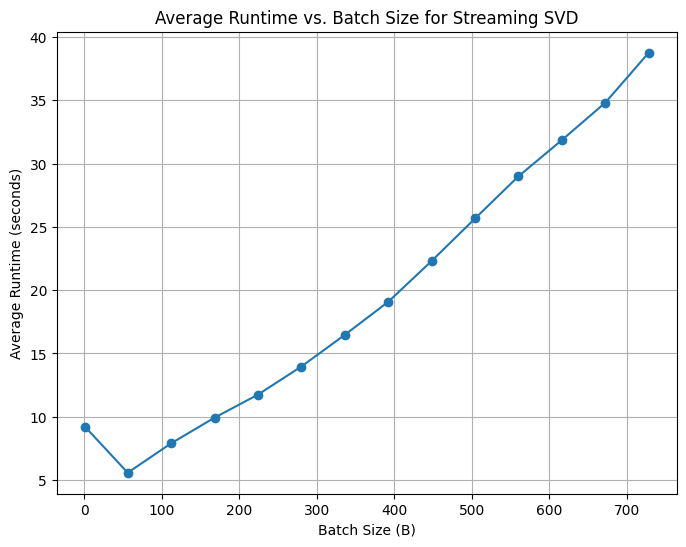

In [138]:
# batch_sizes = [10, 20, 50, 100, 200, 500]
batch_sizes = get_batch_sizes(x_train, 56)

num_singular_values = 3
forget_factor = 1.0
num_trials = 10

runtimes = measure_runtime(batch_sizes, num_trials, num_singular_values, forget_factor)
plot_runtimes_batchsize(batch_sizes, runtimes)

In [139]:
def plot_singular_vectors(U_matrix, num_vectors, title, fig, axes, start_idx=0):

    for i in range(num_vectors):
        singular_vector = U_matrix[:, i]
        singular_vector_image = get_grayscale(singular_vector)

        ax = axes[start_idx + i]
        ax.imshow(singular_vector_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f"{title} Singular Vector {i+1}")
        ax.axis('off')

In [140]:
def plot_comparison_singular_vectors(U_full, U, forget_factor, num_vectors=3):

    output_file = f"svd_comparison_{forget_factor}.png"

    fig, axes = plt.subplots(2, num_vectors, figsize=(num_vectors * 5, 10))
    fig.suptitle(f"Comparison of Singular Vectors\nForget Factor: {forget_factor}", fontsize=16)

    # Plot singular vectors from full SVD
    plot_singular_vectors(U_full, num_vectors, "Full SVD", fig, axes[0])

    # Plot singular vectors from streaming SVD
    plot_singular_vectors(U, num_vectors, "Streaming SVD", fig, axes[1])

    plt.tight_layout()
    plt.savefig(output_file)
    plt.close(fig)
    print(f"Plot saved as {output_file}")

In [141]:
def compare_svd_ff(batch_size, forget_factors, num_singular_values):

    A_full = get_full_mnist_data(x_train)

    # perform SVD using numpy
    U_full, D_full, Vt_full = np.linalg.svd(A_full, full_matrices=False)
    # print(f"First {num_singular_values} Singular Vector From Full SVD: \n {U_full[:, :num_singular_values]}")

    singular_vectors = {}

    for forget_factor in forget_factors:

        print(f"Forget Factor: {forget_factor}")

        # get MNIST data in the required batch size
        A_list = get_mnist_data(x_train, batch_size)

        # perform streaming SVD
        U_list, _ = streaming_svd(A_list, num_singular_values, forget_factor)

        # Access the last batch's singular vectors
        U_last_batch = U_list[-1]  # Get the singular vectors from the last batch processed
        # print(f"Forget Factor: {forget_factor}, \n Singular Value Vectors: {U_last_batch}")

        plot_comparison_singular_vectors(U_full, U_last_batch, forget_factor, num_singular_values)

In [142]:
# compare svd generated by streaming svd and numpy svd for different forget factors
batch_size = 50
forget_factors = [0.0, 0.25, 0.5, 0.75, 1.0]
num_singular_values = 3

compare_svd_ff(batch_size, forget_factors, num_singular_values)

Forget Factor: 0.0
Number of batches: 1200
Shape of each batch: (784, 50)
Plot saved as svd_comparison_0.0.png
Forget Factor: 0.25
Number of batches: 1200
Shape of each batch: (784, 50)
Plot saved as svd_comparison_0.25.png
Forget Factor: 0.5
Number of batches: 1200
Shape of each batch: (784, 50)
Plot saved as svd_comparison_0.5.png
Forget Factor: 0.75
Number of batches: 1200
Shape of each batch: (784, 50)
Plot saved as svd_comparison_0.75.png
Forget Factor: 1.0
Number of batches: 1200
Shape of each batch: (784, 50)
Plot saved as svd_comparison_1.0.png
